### driftkit

LLM-powered pyschogeographic exploration.

In [ ]:
# Various dependencies needed
! pip install -U langgraph --quiet
! pip install -U langchain-anthropic --quiet
! pip install -U langchain_openai --quiet
! pip install -U langchain --quiet
! pip install -U langchainhub --quiet
! pip install -U python-dotenv --quiet

In [1]:
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

True

In [2]:
import os
import requests
import urllib
from typing import List, Dict, Any, Optional
from pydantic import BaseModel

# Read API key from environment variable
GOOGLE_MAPS_API_KEY = os.environ.get('GMAPS_API_KEY')
if not GOOGLE_MAPS_API_KEY:
    raise ValueError("GMAPS_API_KEY environment variable is not set")

# Define constants
GEOCODING_API_URL = "https://maps.googleapis.com/maps/api/geocode/json"
PLACES_API_URL = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
DIRECTIONS_API_URL = "https://maps.googleapis.com/maps/api/directions/json"
STATIC_MAP_API_URL = "https://maps.googleapis.com/maps/api/staticmap"

class Coordinates(BaseModel):
    lat: float
    lon: float

class Location(BaseModel):
    id: str
    name: str
    coordinates: Coordinates
    address: str
    types: List[str]

class RouteStep(BaseModel):
    start_location: Coordinates
    end_location: Coordinates
    distance: float  # in meters
    duration: float  # in seconds
    instructions: str

class StreetNavigator:
    def __init__(self, max_locations: Optional[int] = None):
        self.current_location: Location = None
        self.visited_locations: List[Location] = []
        self.detailed_route: List[RouteStep] = []
        self.max_locations = max_locations

    def start_route(self, address: str) -> Dict[str, Any]:
        """
        Start a new route from the given address.
        """
        coords, formatted_address = self._geocode(address)
        self.current_location = Location(
            id="start",
            name="Start Location",
            coordinates=coords,
            address=formatted_address,
            types=["route_start"]
        )
        self.visited_locations = [self.current_location]

        return {
            "status": "success",
            "message": "Route started",
            "current_location": self.current_location.dict(),
            "locations_visited": 1
        }

    def get_next_possible_destinations(self) -> Dict[str, Any]:
        """
        Get a list of possible next destinations from the current location.
        """
        if not self.current_location:
            return {"status": "error", "message": "No route started"}

        if self.max_locations and len(self.visited_locations) >= self.max_locations:
            return {
                "status": "complete",
                "message": "Maximum number of locations visited",
                "locations_visited": len(self.visited_locations)
            }

        nearby_places = self._get_nearby_places()
        unvisited_places = [place for place in nearby_places if place.id not in [loc.id for loc in self.visited_locations]]

        destinations = []
        for place in unvisited_places:
            destinations.append({
                "id": place.id,
                "name": place.name,
                "address": place.address,
                "types": place.types,
                "coordinates": place.coordinates.dict()
            })

        return {
            "status": "success",
            "destinations": destinations,
            "locations_visited": len(self.visited_locations)
        }

    def navigate(self, location_id: str) -> Dict[str, Any]:
        """
        Navigate to the specified location, including walking directions.
        """
        if not self.current_location:
            return {"status": "error", "message": "No route started"}

        if self.max_locations and len(self.visited_locations) >= self.max_locations:
            return {
                "status": "complete",
                "message": "Maximum number of locations visited",
                "locations_visited": len(self.visited_locations)
            }

        destinations = self.get_next_possible_destinations()
        if destinations["status"] != "success":
            return destinations

        chosen_destination = next((d for d in destinations["destinations"] if d["id"] == location_id), None)

        if not chosen_destination:
            return {"status": "error", "message": "Invalid location ID"}

        new_location = Location(**chosen_destination)
        
        # Get walking directions
        walking_directions = self._get_walking_directions(self.current_location.coordinates, new_location.coordinates)
        
        # Update the detailed route
        self.detailed_route.extend(walking_directions)
        
        # Update current location and visited locations
        self.current_location = new_location
        self.visited_locations.append(new_location)

        return {
            "status": "success",
            "message": "Navigated to new location",
            "current_location": self.current_location.dict(),
            "locations_visited": len(self.visited_locations),
            "last_leg_steps": len(walking_directions),
            "total_route_steps": len(self.detailed_route)
        }

    def end_navigation(self) -> Dict[str, Any]:
        """
        End the current navigation session and clear the state of the class.
        """
        route_summary = [loc.dict() for loc in self.visited_locations]
        locations_visited = len(self.visited_locations)
        total_distance = sum(step.distance for step in self.detailed_route)
        total_duration = sum(step.duration for step in self.detailed_route)
        
        # Clear the state
        self.current_location = None
        self.visited_locations = []
        self.detailed_route = []

        return {
            "status": "success",
            "message": "Navigation ended",
            "route_summary": route_summary,
            "locations_visited": locations_visited,
            "total_distance_meters": total_distance,
            "total_duration_seconds": total_duration,
            "total_route_steps": len(self.detailed_route)
        }

    def _geocode(self, address: str) -> tuple[Coordinates, str]:
        """
        Convert an address to coordinates and formatted address.
        """
        params = {
            'address': address,
            'key': GOOGLE_MAPS_API_KEY
        }
        response = requests.get(GEOCODING_API_URL, params=params)
        data = response.json()
        if data['status'] == 'OK':
            location = data['results'][0]['geometry']['location']
            formatted_address = data['results'][0]['formatted_address']
            return Coordinates(lat=location['lat'], lon=location['lng']), formatted_address
        else:
            raise ValueError(f"Geocoding failed: {data['status']}")

    def _get_nearby_places(self) -> List[Location]:
        """
        Get nearby places from the current location.
        """
        params = {
            'location': f"{self.current_location.coordinates.lat},{self.current_location.coordinates.lon}",
            'radius': 500,
            'type': 'point_of_interest',
            'key': GOOGLE_MAPS_API_KEY
        }
        response = requests.get(PLACES_API_URL, params=params)
        data = response.json()

        places = []
        if data['status'] == 'OK':
            for place in data['results']:
                place_location = place['geometry']['location']
                places.append(Location(
                    id=place['place_id'],
                    name=place['name'],
                    coordinates=Coordinates(lat=place_location['lat'], lon=place_location['lng']),
                    address=place.get('vicinity', 'Address not available'),
                    types=place['types']
                ))
        return places

    def _get_walking_directions(self, start: Coordinates, end: Coordinates) -> List[RouteStep]:
        """
        Get walking directions between two points.
        """
        params = {
            'origin': f"{start.lat},{start.lon}",
            'destination': f"{end.lat},{end.lon}",
            'mode': 'walking',
            'key': GOOGLE_MAPS_API_KEY
        }
        response = requests.get(DIRECTIONS_API_URL, params=params)
        data = response.json()

        route_steps = []
        if data['status'] == 'OK':
            for step in data['routes'][0]['legs'][0]['steps']:
                route_steps.append(RouteStep(
                    start_location=Coordinates(lat=step['start_location']['lat'], lon=step['start_location']['lng']),
                    end_location=Coordinates(lat=step['end_location']['lat'], lon=step['end_location']['lng']),
                    distance=step['distance']['value'],
                    duration=step['duration']['value'],
                    instructions=step['html_instructions']
                ))
        return route_steps
    
    def visualize_route(self, output_file: str = "route_map.png"):
        """
        Visualize the detailed route using Google Maps Static API.
        """
        if not self.detailed_route:
            print("No route to visualize.")
            return

        # Prepare the path for the route
        path_points = []
        for step in self.detailed_route:
            path_points.append(f"{step.start_location.lat},{step.start_location.lon}")
            path_points.append(f"{step.end_location.lat},{step.end_location.lon}")

        # Deduplicate path points to reduce URL length
        path_points = list(dict.fromkeys(path_points))

        # Prepare markers for start and end points
        start_marker = f"color:green|label:S|{self.visited_locations[0].coordinates.lat},{self.visited_locations[0].coordinates.lon}"
        end_marker = f"color:red|label:E|{self.visited_locations[-1].coordinates.lat},{self.visited_locations[-1].coordinates.lon}"

        # Construct the base URL
        base_url = f"{STATIC_MAP_API_URL}?size=640x640&scale=2&maptype=roadmap&key={GOOGLE_MAPS_API_KEY}"

        # Add markers
        base_url += f"&markers={urllib.parse.quote(start_marker)}&markers={urllib.parse.quote(end_marker)}"

        # Add path
        encoded_path = urllib.parse.quote("|".join(path_points))
        path_url = f"&path=color:0x0000ff|weight:5|{encoded_path}"

        # Check if the URL is too long and simplify if necessary
        if len(base_url + path_url) > 8192:
            print("Warning: URL too long. Simplifying path...")
            # Simplify by reducing the number of path points
            simplified_path = path_points[::len(path_points)//100 + 1]  # Take every nth point
            encoded_path = urllib.parse.quote("|".join(simplified_path))
            path_url = f"&path=color:0x0000ff|weight:5|{encoded_path}"

        final_url = base_url + path_url

        try:
            # Make the request to the Static Map API
            response = requests.get(final_url)
            response.raise_for_status()

            # show image in Jupyter Notebook
            from IPython.display import Image, display
            display(Image(response.content))
        except requests.RequestException as e:
            print(f"Failed to generate map. Error: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

In [4]:
from typing import List

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig

from langgraph.prebuilt import ToolNode

navigator = StreetNavigator(max_locations=5)

@tool(parse_docstring=True)
def navigate(
    location_id: str,
    config: RunnableConfig,
) -> None:
    """Navigate to a location.

    Args:
        location_id: ID of the location to navigate to.
    """
    navigator = config.get("configurable", {}).get("navigator")
    return navigator.navigate(location_id)

@tool
def get_next_possible_destinations(config: RunnableConfig) -> None:
    """Get next possible destinations."""
    navigator = config.get("configurable", {}).get("navigator")
    return navigator.get_next_possible_destinations()

tools = [navigate, get_next_possible_destinations]
tool_node = ToolNode(tools)



In [5]:
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


model_with_tools = ChatAnthropic(model="claude-3-5-sonnet-20240620").bind_tools(tools)

In [6]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


builder = StateGraph(MessagesState)

# Define the two nodes we will cycle between
builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)

builder.add_edge(START, "agent")
builder.add_conditional_edges("agent", should_continue, ["tools", END])
builder.add_edge("tools", "agent")

graph = builder.compile()

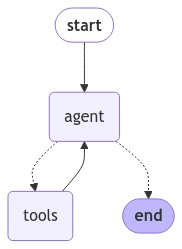

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
from langchain_core.messages import HumanMessage

navigator.end_navigation()
navigator.start_route("Washington Square, San Francisco")

PROMPT = """You are an urban pyschogeographer. 
Choose an interesting and inspiring route to explore, pay attention to the details.
A novel and unexpected next destination should be selected so that you can explore the city in a new way.
ALWAYS get a list of possible destinations before navigating to the next location."""

inputs = {"messages": [HumanMessage(content=PROMPT)]}
for chunk in graph.stream(
    inputs, {"configurable": {"navigator": navigator}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()



================================ Human Message =================================

You are an urban pyschogeographer. 
Choose an interesting and inspiring route to explore, pay attention to the details.
A novel and unexpected next destination should be selected so that you can explore the city in a new way.
ALWAYS get a list of possible destinations before navigating to the next location.
================================== Ai Message ==================================

[{'text': "Certainly! As an urban psychogeographer, I'll guide us through an interesting and inspiring route, paying close attention to the details and selecting novel, unexpected destinations to explore the city in a new way. Let's begin our journey by first getting a list of possible destinations.", 'type': 'text'}, {'id': 'toolu_01Ugz2X7NFPmwB5NcX3JGv8d', 'input': {}, 'name': 'get_next_possible_destinations', 'type': 'tool_use'}]
Tool Calls:
  get_next_possible_destinations (toolu_01Ugz2X7NFPmwB5NcX3JGv8d)
 Call ID: to

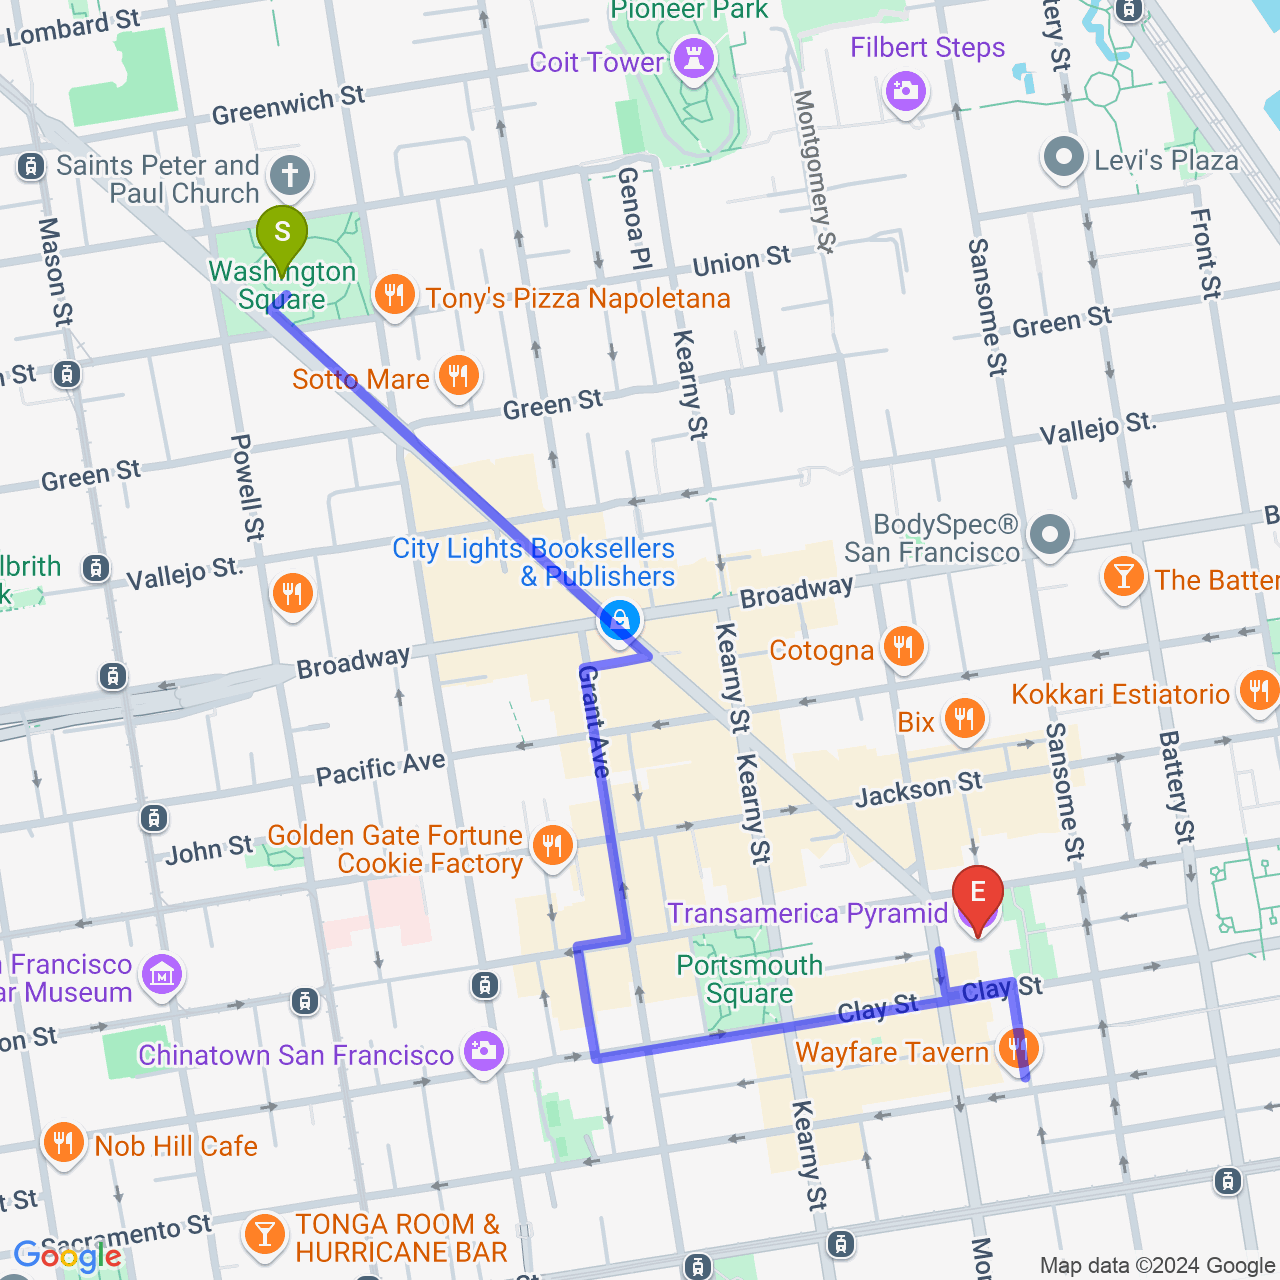

In [9]:
navigator.visualize_route()